In [27]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
import datetime

from models.aae_pyramid import Encoder, Decoder, Discriminator, train, gaussian_sample
from tools.logging import Logger

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

PROC_DIR = Path('../data/processed')
flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']


Using device:  cuda:0


# Helper Functions

In [40]:
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
    
def plot_unscaled_clusters(labels, nclusters, filenames, columns, yscale={}, save_path=None):
    """Plot cluster of the original data (not scaled)"""  
    
    if (nclusters < 2):
        print("Not enough clusters to plot")
        return
    
    _fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(4*len(columns), 4*nclusters))
    for idx, filename in enumerate(filenames):
        
        flow = pd.read_csv(PROC_DIR / f"{filename}.csv")
        
        for col_pos, col in enumerate(columns):
            axs[(labels[idx], col_pos)].plot(flow[col], linewidth=0.5)
            axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))
        axs[(labels[idx], 1)].set_title("Cluster " + str(labels[idx]))
                 
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    plt.show()
  
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plot_cluster_file_group(filenames, labels, nclusters):
    # get filegroups and create a dict with the number of files per cluster
    locs = set([l.split('_')[2] for l in filenames])
    cluster_file_distr = {loc:[0 for _ in range(nclusters)] for loc in locs}

    # count the number of files per cluster
    for f, c in zip(filenames, labels):
        loc = f.split('_')[2]
        cluster_file_distr[loc][c] += 1
    cluster_file_distr = dict(sorted(cluster_file_distr.items()))
    print(cluster_file_distr)
    
    # arrange data for plotting
    cluster_ids = sorted(list(set(labels)))
    # move -1 to the end in the case of dbscan
    if -1 in cluster_ids:
        cluster_ids = cluster_ids[1:] + [-1]

    print(cluster_ids)
    tmp_dict = {"group" : [], "cluster" : [], "count" : []}
    for f, v in cluster_file_distr.items():
        for idx, count in zip(cluster_ids, v):
            tmp_dict["group"].append(f)
            tmp_dict["cluster"].append(idx)
            tmp_dict["count"].append(count)
            
    fig, ax = plt.subplots(figsize=(10, 5))       
    sns.barplot(x="group", y="count", hue="cluster", data=pd.DataFrame(tmp_dict), ax=ax)
    ax.set_xlabel("File Group")
    ax.set_ylabel("Number of files")
    ax.set_title("Number of files per cluster per file group")
    fig.legend(loc="center right", title="Cluster")
    ax.get_legend().remove()
    return fig

In [20]:
def fit(dataloader, nclusters : int):
    netEnc = Encoder(
        input_size=dataloader.dataset.shape[1],
        hidden_size=512,
        l_dim=2,  
        device=device,
        slope=0.2
    ).to(device)

    netDec = Decoder(
        output_size=dataloader.dataset.shape[1],
        l_dim=2,
        hidden_size=32,
        slope=0.2
    ).to(device)

    netD = Discriminator(
        l_dim=2,
        hidden_size=256,
        slope=0.2
    ).to(device)
    
    time_id = datetime.datetime.now().strftime("%m%d-%H%M")
    
    class GaussianOpts:
        def __init__(self) -> None:
            self.nclusters = nclusters
            self.radius = 1
            self.sigma = 0.02 # dispersion of the cluster
            self.dim = 2      # dimentionality of each guassian distribution    
    class Options:
        def __init__(self):
            self.l_dim = 2
            # Train params
            self.G_lr = 0.0001
            self.D_lr = 0.0002
            self.epochs = 400
            self.sample_interval = 100
            self.train_plots = True
            
            # create ouput dirs
            self.model_out = Path(f'./runs/aae2D/{nclusters}clusters_' + time_id)
            if not self.model_out.exists(): self.model_out.mkdir(parents=True)
            (self.model_out / "img").mkdir(exist_ok=True)
            
            # logging
            self.tags = ["aae", "joint", "minmax", "cluster", "test"]
            self.desc = f"AAE cluster ({nclusters})"
            self.type = "AAE (cluster)" 
    gopts = GaussianOpts()
    opts = Options()
    
    logger = Logger([netEnc, netDec, netD], opts.model_out / f"{time_id}.md", vars(opts))

    train(netEnc, netDec, netD, dataloader, opts, gopts, device)
    
    return netEnc, netDec, netD, opts
    
def transform(netEnc : Encoder, dataloader : DataLoader, opts):
    points = np.empty((0, opts.l_dim))
    all_files = []
    netEnc.eval()
    for _i, (x, filenames) in enumerate(dataloader):
        x = x.to(device)
        enc_x = netEnc(x)
        enc_x = enc_x.detach().cpu().numpy()
        points = np.vstack([points, enc_x])
        all_files.extend(filenames)
    points = np.array(points)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(points[:, 0], points[:, 1], s=1)
    plt.savefig(opts.model_out / "img" / "test_scatter.png")
    
    return points, all_files

# Dataset

In [6]:
dataset = MULTI_VP_Dataset(
    path=Path('../data/compiled/inputs.csv'),
    method="joint",
    remove_extreme=False,
    is_train=True,
    scaler=MinMaxScaler((0,1)),
)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=False)

Inputs shape: (11771, 1280)
Inputs head:
 [[0.07901409 0.07770413 0.07639258 ... 0.         0.         0.        ]
 [0.08061006 0.07927175 0.07793188 ... 0.         0.         0.        ]
 [0.08461927 0.08321194 0.08180305 ... 0.         0.         0.        ]
 [0.07792335 0.07662926 0.07533369 ... 0.         0.         0.        ]
 [0.0831087  0.08172403 0.08033791 ... 0.         0.         0.        ]]


# 2 Clusters

In [11]:
netEnc, netDec, netD, opts = fit(dataloader, 2)

Starting Training Loop...


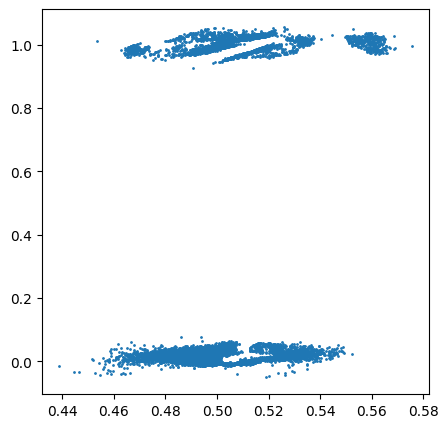

In [21]:
netEnc.eval()
transformed, filenames = transform(netEnc, dataloader, opts)

In [42]:
sns.set()

## KMeans

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

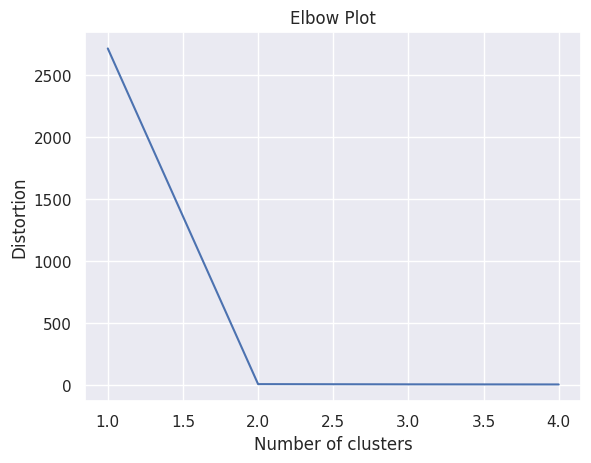

In [43]:
# Elbow Test
distortions = []
K = range(1, 5)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

<AxesSubplot: >

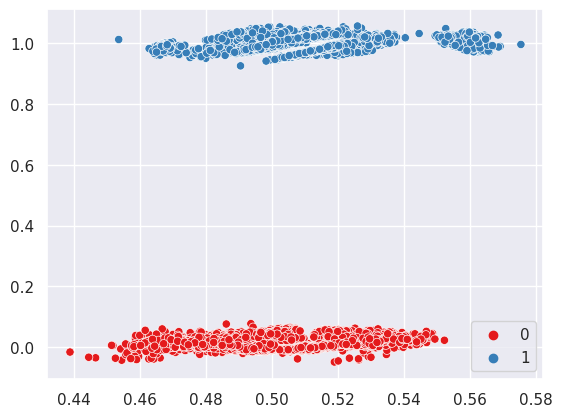

In [44]:
kmeans = KMeans(n_clusters=2,max_iter=500, n_init='auto')
kmeans_labels = kmeans.fit_predict(transformed)
nclusters = len(set(kmeans_labels))

sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=kmeans_labels, palette='Set1')

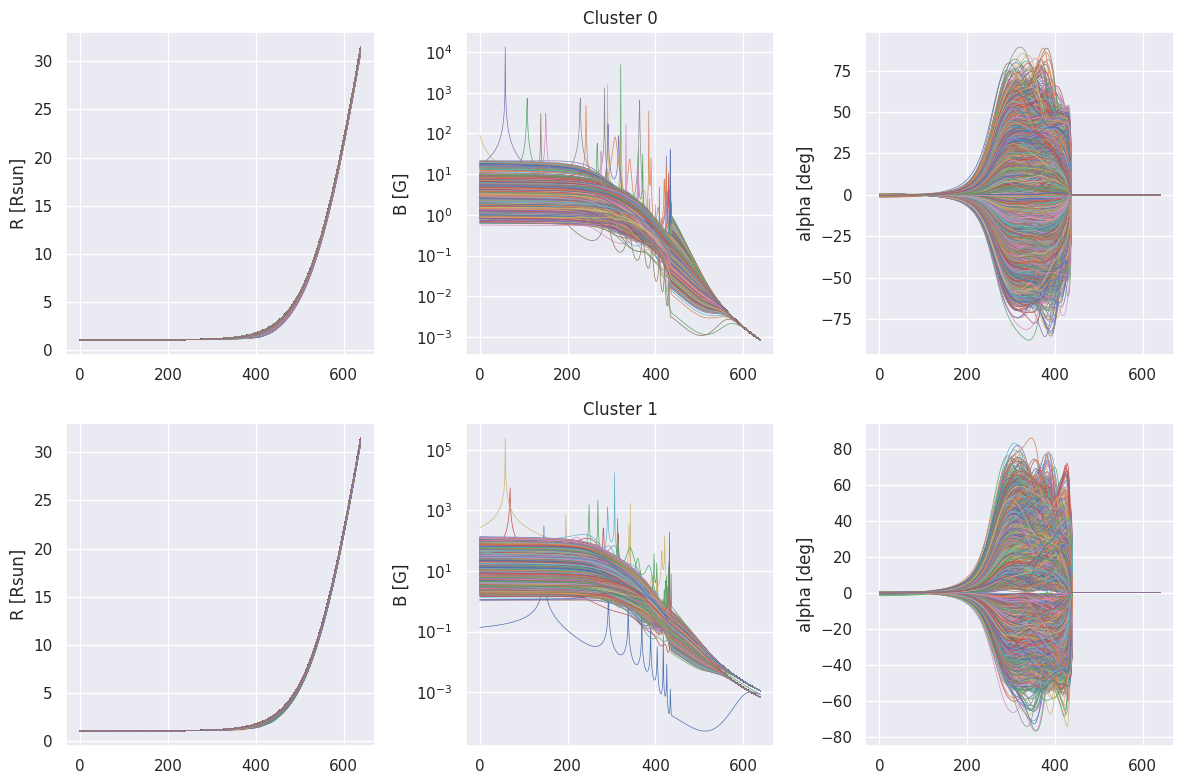

In [45]:
plot_unscaled_clusters(kmeans_labels, nclusters, filenames, flow_columns, yscale={'B [G]': 'log'})

### Distributions

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

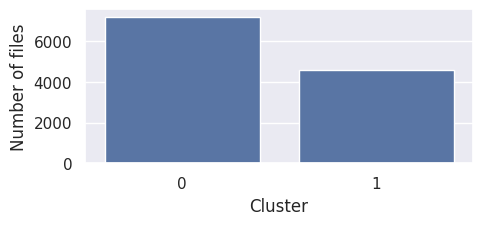

In [46]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [0, 2500], 'CR2056': [2560, 2], 'CR2071': [2173, 0], 'CR2125': [0, 2063], 'CR2210': [2473, 0]}
[0, 1]


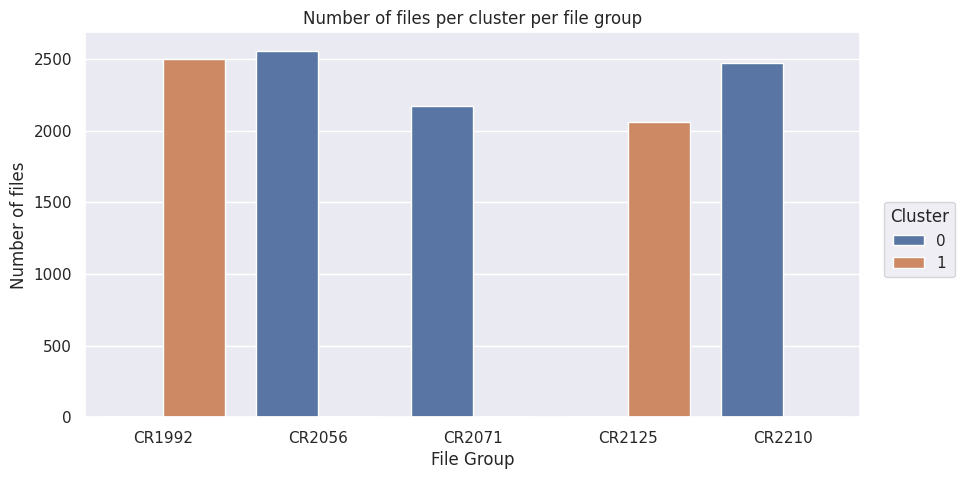

In [47]:
fig = plot_cluster_file_group(filenames, kmeans_labels, nclusters)

# 3 Clusters

In [ ]:
netEnc, netDec, netD, opts = fit(dataloader, 2)